# Custom Distributions

You might want to model input uncertanty with a distribution not currenlty available in Golem. In this case you can create your own class implementing such distribution.

Here, we will reimplement a uniform distribution as a toy example.

In [1]:
from golem import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(context='talk', style='ticks')

To create your own distribution class to be used in Golem, you need to create a class that:

(1) Inherits from the ``BaseDist`` class;

(2) Implements a ``cdf`` method that returns the cumulative density for the distribution of interest. The ``cdf`` method needs to to take in two arguments, ``x`` and ``loc``. ``loc`` is the location of the distribution, e.g. the mean for a Gaussian, and ``x`` is where the CDF needs to be evaluated at. 


In addition, even though this is not required for the code to run, the ``__init__`` method should allow to define the scale of the distribution. In the example below, we allow the user to define the range of the uniform. For a Gaussian distribution this would be the standard deviation, and so on.

In [2]:
# Here is a custom, user-implemented, uniform distribution class

class MyDistribution(BaseDist):

    def __init__(self, urange):
        self.urange = urange

    
    def cdf(self, x, loc):
        """Cumulative density function.

        Parameters
        ----------
        x : float
            The point where to evaluate the cdf.
        loc : float
            The location of the Uniform distribution.
            
        Returns
        -------
        cdf : float
            Cumulative density evaluated at ``x``.
        """
        a = loc - 0.5 * self.urange
        b = loc + 0.5 * self.urange

        # calc cdf
        if x < a:
            return 0.
        elif x > b:
            return 1.
        else:
            return (x - a) / (b - a)

To demonstrate how this can be used, we use a simple objective function and we will compute its robust counterpart using the ``Uniform`` class available in Golem as well as the above, user-defined equivalent ``MyDistribution``.

In [3]:
# a sample 1d objective function
def objective(x):
    
    def sigmoid(x, l, k, x0):
        return l / (1 + np.exp(-k*(x-x0)))

    sigs = [sigmoid(x,  1, 100, 0.1),
            sigmoid(x, -1, 100, 0.2),
            sigmoid(x,  0.7, 80, 0.5),
            sigmoid(x, -0.7, 80, 0.9)
           ]
    return np.sum(sigs, axis=0)

First, using the ``Golem.Uniform`` class...

[INFO] Golem ... 1 tree(s) parsed in 53.26 ms ...
[INFO] Golem ... Convolution of 1000 samples performed in 6.25 ms ...


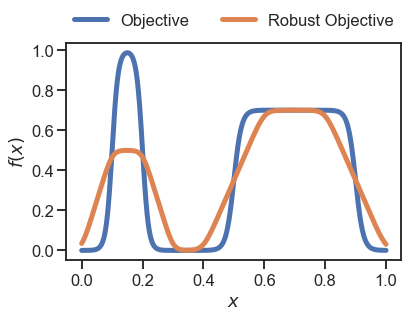

In [4]:
# take 1000 samples in x
x = np.linspace(0, 1, 1000)

# compute objective
y = objective(x)

# compute robust objective with Golem
golem = Golem(goal='max', random_state=42, nproc=1)
golem.fit(X=x.reshape(-1,1), y=y)

# use the Golem.Uniform class here
dists = [Uniform(0.2)]
y_robust = golem.predict(X=x.reshape(-1,1), distributions=dists)

# plot results
plt.plot(x, y, linewidth=5, label='Objective')
plt.plot(x, y_robust, linewidth=5, label='Robust Objective')

_ = plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5 ,1.), frameon=False)
_ = plt.xlabel('$x$')
_ = plt.ylabel('$f(x)$')

...then with our new custom ``MyDistribution`` class:

[INFO] Golem ... Convolution of 1000 samples performed in 297.95 ms ...


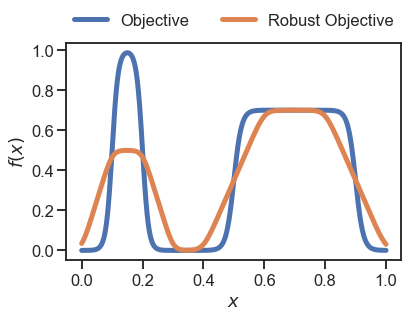

In [5]:
# use MyDistribution for the prediction/convolution
dists = [MyDistribution(0.2)]
y_robust = golem.predict(X=x.reshape(-1,1), distributions=dists)

# plot the results
plt.plot(x, y, linewidth=5, label='Objective')
plt.plot(x, y_robust, linewidth=5, label='Robust Objective')

_ = plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5 ,1.), frameon=False)
_ = plt.xlabel('$x$')
_ = plt.ylabel('$f(x)$')

As you can see, the result above (orange line) obtained with the user-defined uniform is the same to that obtained with ``Golem.Uniform`` as expected.

However, note that while with ``Golem.Uniform`` the 1000 samples were processed in less than 10 ms, with ``MyDistribution`` it took almost 300 ms (~30 times slower). This is because the method ``cdf`` is called many times (about 1 million times in this example) and ``Golem.Uniform`` is implemented in Cython rather than Python. Therefore, if the execution time of the ``predict`` method in Golem with your custom distribution is too slow, you shuold consider a Cython implementation.